Kotug Project, Group 1

Allan Guzman, June Chen, Sarah Blanc

Let's maybe first remember here the research questions of this project:

**Main Research Question**:

"How can the reliability and efficiency of Kotug OptiPort's tugboat scheduling tool be enhanced through the development and evaluation of novel methods for predicting pickup and drop-off coordinates and other relevant variables?"

**Subresearch Questions**:

- "What advanced predictive methods can be developed and implemented to accurately forecast the coordinates (latitude and longitude) for pickup and drop-off locations of tugs on vessels in the port of Rotterdam?"
- "Which variables, including AIS data, customer requirements, and port-specific constraints (or lack thereof), play a significant role in determining the pickup and drop-off locations and timing of tugs, as well as the required number of tugs for each vessel operation in the port of Rotterdam, and why are they important?"
- "Which of the above mentioned variables can be combined in order to increase the reliability of the results, and why can they be combined?"

The work on this first research question in done in the file called "Prediction", while the 2 other subquestions are answered in this file. 

**DATA PROCESSING** 

Data processing refers to the transformation of raw data into meaningful and actionable insights. It includes a set of procedures that transform data into a form that can be used for analysis, interpretation, and making decisions. This vital procedure is essential for a number of reasons, all of which support the overall effectiveness and success of this data science project.
1. Extracting insights from our raw data: in its purest form, our raw data lacks organisation and clarity. In order to make sure the data is reliable and consistent, it must be cleaned, and arranged. This conversion makes it easier to extract insightful information that may be applied to a our forecasting method.
2. Enhancing data quality: it helps in identifying and rectifying errors, inconsistencies, and inaccuracies within our data. We may make decisions based on trustworthy information and achieve better results and more operational efficiency.
3. Facilitating data integration: in this project, we work with data from several sources. data processing allows us to harmonise and integrate our data into a single format. 

In this file, you can aslo find visualizations of the Rotterdam DataSet, especially the port and the method with the squares (dsicretization) that we decide to use.

In [1]:
# Define the diagonal length for each grid cell in meters (500 meters)
diagonal_length_meters = 1000.0

## Import of the librairies

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from ipyleaflet import Map, GeoJSON, GeoData, basemaps, LayersControl
from shapely.geometry import Point, Polygon, LineString
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
import rasterio
import rasterio.mask
from rasterio.plot import reshape_as_image 
from rasterio.plot import reshape_as_raster
from shapely.ops import unary_union

import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.spatial import KDTree
import numpy as np
from shapely.geometry import LineString

from shapely.ops import nearest_points

from scipy.interpolate import BSpline


**Historic Towages Data**

In [3]:
# Opening JSON file
f = open('Data/Input_EDA/historic_towages.json')
#f = open('Data/Input_EDA/historic_towages.json')
 
# returns JSON object as a dictionary
tow_data = json.load(f)
 
# Closing file
f.close()

**Processing of the grid/the water surface in the port of Rotterdam**

Visualization of the water, within the Port of Rotterdam

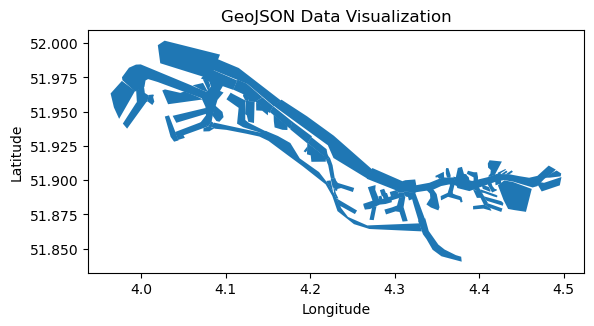

In [4]:
# Load the GeoJSON data from your file
file_path = 'Data/Input_EDA/haven.txt'
#file_path = 'Data/Input_EDA/haven.txt'
gdf_haven = gpd.read_file(file_path)
gdf_haven.dropna(axis=1)

# Plot the GeoDataFrame
gdf_haven.plot()
plt.title('GeoJSON Data Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Visualization of the polygons representing the in-port water

In [5]:
# Create a map to visualize the areas
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11,
    
)
gjson = folium.features.GeoJson(gdf_haven).add_to(poly_map)

poly_map


Merge of all the polygons

In [6]:
#Merge of the polygons
merged_haven = unary_union(gdf_haven['geometry'])

poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)
gjson = folium.features.GeoJson(merged_haven).add_to(poly_map)

poly_map


As evident from the preceding map, the boundaries are somewhat ambiguous, with a substantial portion of land appearing as water (a closer look will reveal this). Consequently, we made the determination to seek more accurate data. A team member took the initiative to meticulously delineate all the coastlines within the Port of Rotterdam manually. This endeavor has enabled us to establish more accurate distinctions for the water boundaries.

In [7]:
# Import waterline from NL 
gdf_coast = gpd.read_file('Data/Input_EDA/NL_Waterline.gml', driver='GML')

In [8]:
# Define the custom coordinate system (modify this with your actual custom CRS)
input_crs = "EPSG:28992"

# Define the target EPSG:4326 CRS
target_crs = "EPSG:4326"

# Create a GeoDataFrame and set the custom CRS
gdf_coast.set_crs(input_crs, allow_override=True, inplace=True)

# Transform the geometries to EPSG:4326
gdf_coast = gdf_coast.to_crs(target_crs)


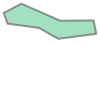

In [9]:
p1 = Point(51.91865, 3.92079)
p2 = Point(51.99519, 3.89333)
p3 = Point(52.0611, 4.01894)
p4 = Point(51.93935, 4.29704)
p5 = Point(51.94185, 4.53538)
p6 = Point(51.84609, 4.5546)
p7 = Point(51.81044, 4.28269)
p8 = Point(51.88806, 4.14468)
points = [p1, p2, p3, p4, p5, p6, p7, p8, p1]

big_area = Polygon([[p.y, p.x] for p in points])
big_area

In [10]:
heaven_and_sea = unary_union((merged_haven,gdf_coast.head(1)['geometry'][0]))
polygon_gdf = gpd.GeoDataFrame(geometry=[heaven_and_sea], crs=gdf_coast.crs)
intersection = gpd.clip(gdf_coast, polygon_gdf)
intersection = intersection[(intersection.geom_type == 'Polygon') | (intersection.geom_type == 'MultiPolygon')]
intersection = intersection[intersection.functie != 'waterzuivering']
intersection = intersection[(intersection.typeWater == 'waterloop') | (intersection.typeWater == 'zee')]
geometry_counts = intersection['typeWater'].value_counts()

intersection_union = unary_union(intersection['geometry'])

Our proposed approach entails delineating the polygon encapsulating the entire water expanse within the Port of Rotterdam into discrete smaller squares. The modification of the square size is a critical parameter ("diagonal_length_meters") that requires careful evaluation of the available processing resources. It is crucial to find the ideal balance between computational viability and accuracy. Although increasing the number of smaller squares improves the discretization's granularity, it is crucial to recognise the computing limitations. An overabundance of detail could impose a strain on the computational infrastructure and hinder the effectiveness of the model. Therefore, it's crucial to make a wise trade-off that balances our available computational resources with precision's smooth integration into the predictive model. 
You can find below the process of discretizing the Polygone that we just created with the new and better coastal boarders.

In [11]:
# The original polygon
original_polygon = gpd.GeoDataFrame(geometry=[big_area], crs=gdf_coast.crs)

# Define the diagonal length for each grid cell in meters (500 meters)

# Convert diagonal length from meters to degrees
def meters_to_degrees(meters):
    # Earth's radius in meters (approximately)
    earth_radius_meters = 6371000.0
    # Calculate the conversion factor from meters to degrees
    degrees_per_radian = 180.0 / np.pi
    radians_per_degree = np.pi / 180.0
    return (meters / earth_radius_meters) * degrees_per_radian

diagonal_length_degrees = meters_to_degrees(diagonal_length_meters)

# Calculate the size of each grid cell
cell_size = diagonal_length_degrees / np.sqrt(2)

# Get the bounding box of the original polygon
bbox = original_polygon.total_bounds  # Returns [minx, miny, maxx, maxy]

# Create a grid of points within the bounding box
x_min, y_min, x_max, y_max = bbox
x_coords = np.arange(x_min, x_max, cell_size)
y_coords = np.arange(y_min, y_max, cell_size)

# Create a list of square polygons as Shapely Polygons
square_polygons = [Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)]) for x in x_coords for y in y_coords]

# Create a GeoDataFrame from the square polygons
grid_gdf = gpd.GeoDataFrame(geometry=square_polygons, crs=original_polygon.crs)



In [12]:
# Filter the grid polygons to keep only those within the original polygon
grid_within_polygon = grid_gdf[grid_gdf.intersects(original_polygon.unary_union)]
grid_within_polygon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2064 entries, 26 to 4130
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  2064 non-null   geometry
dtypes: geometry(1)
memory usage: 32.2 KB


In [13]:
grid_within_polygon = gpd.clip(grid_within_polygon, intersection)
grid_within_polygon.reset_index(inplace = True)
grid_within_polygon.rename(columns={"index": "area_ID"}, inplace = True)

In [14]:
grid_within_polygonbis = grid_within_polygon.copy()
grid_within_polygonbis['center'] = grid_within_polygonbis['geometry'].centroid
grid_within_polygonbis

/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/2992409516.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_within_polygonbis['center'] = grid_within_polygonbis['geometry'].centroid


,area_ID,geometry,center
0,3044,"POLYGON ((4.37663 51.84224, 4.37914 51.84224, ...",POINT (4.37785 51.84172)
1,3004,"POLYGON ((4.37663 51.84224, 4.37663 51.84101, ...",POINT (4.37481 51.84177)
2,3045,"POLYGON ((4.37663 51.84224, 4.37663 51.84397, ...",POINT (4.37779 51.84309)
3,2965,"POLYGON ((4.37027 51.84256, 4.36966 51.84269, ...",POINT (4.36703 51.84475)
4,3005,"POLYGON ((4.37663 51.84224, 4.37199 51.84224, ...",POINT (4.37325 51.84349)
...,...,...,...
894,434,"POLYGON ((3.96328 52.02665, 3.95692 52.02665, ...",POINT (3.96012 52.02786)
895,634,"POLYGON ((3.99508 52.02665, 3.98872 52.02665, ...",POINT (3.99191 52.02810)
896,474,"POLYGON ((3.96964 52.02665, 3.96328 52.02665, ...",POINT (3.96648 52.02791)
897,594,"POLYGON ((3.98872 52.02665, 3.98236 52.02665, ...",POINT (3.98556 52.02805)


The final grid can be visualized below. This is the grid that is going to be used for the predictions method.

In [15]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(grid_within_polygon).add_to(poly_map) 

poly_map

**Data Processing: the tugs and vessels information**

This stage holds paramount importance for the progression of the project. Here, our main goal is to carefully clean and prepare the several dataframes that are needed in order to use the prediction techniques. It is necessary to recognise that the data that has been supplied is, in its natural state, inadequate and inappropriate for our needs at this time. A great deal of work has gone into fixing the numerous problems that the datasets include. Given the sheer enormity of some datasets (ais data sets), a specialized tool in the realm of data science was employed to streamline part of the data processing. This concerns the data about the vessels (dimensions: lenght and width, draught, and type). This tool, called Alteryx Designer, proved instrumental in handling the intricacies of large datasets efficiently. Indeed, Alteryx Designer is a powerful data analytics and visualization tool that allows users to prepare, blend, and analyze data quickly and efficiently. The decision to opt for this tool was driven by the extensive time required to load the data for each month when utilizing Python on our computers. Due to this extended period, we decided to utilise the knowledge of a team member who had previously worked with Alteryx Designer.

Furthermore, it is important to mention that after a discussion with the employees of Kotug, only the first pick-up and the last drop-off locations have to be predicted. This means that if many tugs help a vessel, only the locations of the first one that pick-up and the last one to drop-off will be predicted.

In [16]:
# Create empty lists to store tugs data and their original JSON index
tugs_data = []
trip_ID = []
vessel_name = []  # Create a list to store previous vessel names
vessel_mmsi = []  # Create a list to store previous vessel names


# Extract tugs data into a separate list, store their original index, and the previous vessel name
for i, item in enumerate(tow_data):
    for tug in item['tugs']:
        tugs_data.append(tug)
        trip_ID.append(i)
        vessel_name.append(item['vessel']['name'])
        vessel_mmsi.append(item['vessel']['mmsi'])


# Create a DataFrame for tugs data with the original index and previous vessel name
tugs_df = pd.DataFrame(tugs_data)
tugs_df['trip_ID'] = trip_ID  # Add original index as a new column
tugs_df['vessel_name'] = vessel_name  # Add vessel name as a new column
tugs_df['vessel_mmsi'] = vessel_mmsi

tugs_df['from'] = pd.to_datetime(tugs_df['from'],format='ISO8601')
tugs_df['to'] = pd.to_datetime(tugs_df['to'],format='ISO8601')

tugs_df['from_rounded'] = tugs_df['from'].dt.round('H')
tugs_df['to_rounded'] = tugs_df['to'].dt.round('H')

# Create a DataFrame for the rest of the data (excluding tugs)
vessel_info = [{'from': item['from'],
               'to': item['to'],
               'vessel': item['vessel'],
               'type': item['type'],
               'additional_data': item['additional_data']}
              for item in tow_data]

vessel_df = pd.DataFrame(vessel_info)

tugs_df = tugs_df.merge(vessel_df['type'], left_on='trip_ID', right_index=True)

In [17]:
tugs_df

,imo,mmsi,name,from,to,from_location,to_location,from_berth,to_berth,from_haven,to_haven,trip_ID,vessel_name,vessel_mmsi,from_rounded,to_rounded,type
0,9695509,244900124,VB MARS,2022-05-31 22:49:33+00:00,2022-06-01 00:10:13+00:00,"[4.06852, 51.98272]","[4.05362, 51.9375]",None,MISSISSIPPIH EMO MH 4,None,MISS,0,NAVIOS LUZ,370604000,2022-05-31 23:00:00+00:00,2022-06-01 00:00:00+00:00,incoming
1,9816658,248352000,ROTTERDAM,2022-05-31 22:49:32+00:00,2022-06-01 00:20:21+00:00,"[4.06852, 51.98272]","[4.05363, 51.93748]",None,MISSISSIPPIH EMO MH 4,None,MISS,0,NAVIOS LUZ,370604000,2022-05-31 23:00:00+00:00,2022-06-01 00:00:00+00:00,incoming
2,9816359,248753000,BEAGLE,2022-05-31 22:54:16+00:00,2022-06-01 00:35:37+00:00,"[4.08358, 51.97713]","[4.05365, 51.93745]",None,MISSISSIPPIH EMO MH 4,None,MISS,0,NAVIOS LUZ,370604000,2022-05-31 23:00:00+00:00,2022-06-01 01:00:00+00:00,incoming
3,9489936,244697000,VB KRACHT,2022-05-31 23:29:57+00:00,2022-06-01 00:30:17+00:00,"[4.0516, 51.94783]","[4.08905, 51.96774]",AMAZONEH ECT DDE,None,AMAZ,None,1,ONE HONG KONG,355271000,2022-05-31 23:00:00+00:00,2022-06-01 01:00:00+00:00,leaving
4,9474905,244791000,RT ROB,2022-05-31 23:20:43+00:00,2022-06-01 00:30:17+00:00,"[4.05166, 51.94792]","[4.08905, 51.96774]",AMAZONEH ECT DDE,None,AMAZ,None,1,ONE HONG KONG,355271000,2022-05-31 23:00:00+00:00,2022-06-01 01:00:00+00:00,leaving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42227,9060704,245906000,THAMESBANK,2023-05-31 22:13:18+00:00,2023-05-31 22:59:18+00:00,"[4.44552, 51.8936]","[4.41163, 51.90059]",WAALH HBR B 23,None,WAAL,None,24491,MTM HAMBURG,566976000,2023-05-31 22:00:00+00:00,2023-05-31 23:00:00+00:00,leaving
42228,9507063,245932000,VB GINGER,2023-05-31 23:04:20+00:00,2023-05-31 23:44:50+00:00,"[4.1589, 51.94893]","[4.1935, 51.93023]",None,CALANDK ETT EAST,None,CKVTTI,24492,ONYX,275484000,2023-05-31 23:00:00+00:00,2023-06-01 00:00:00+00:00,incoming
42229,9060704,245906000,THAMESBANK,2023-05-31 23:09:28+00:00,2023-05-31 23:44:56+00:00,"[4.39814, 51.87972]","[4.38662, 51.89737]",ALEXANDERH ZZ 2,None,PWAH,None,24493,WINDSWEPT,563169400,2023-05-31 23:00:00+00:00,2023-06-01 00:00:00+00:00,leaving
42230,9120190,205233000,UNION 11,2023-05-31 23:04:17+00:00,2023-05-31 23:49:58+00:00,"[4.39814, 51.87972]","[4.37126, 51.89949]",ALEXANDERH ZZ 2,None,PWAH,None,24493,WINDSWEPT,563169400,2023-05-31 23:00:00+00:00,2023-06-01 00:00:00+00:00,leaving


Addition of the weather data (direction of the wind and wind speed)
We categorized them in excel, in order to be able to use them in the prediction model. We chose to have 8 categories for the wind speed (N, NE, E, SE, S, SW, W, NW) and 4 categories for the wind speed (Low, Mid, High, Extreme). We collected the data for the 31st of May 2022, till the 2nd of June 2023. This idea here was to take a little buffer margin on the time intervall, so we were sure to get at least all the data needed.

In [18]:
wind = pd.read_csv('Data/Input_EDA/Weather.csv')
wind['Datetime'] =  pd.to_datetime(wind['Datetime'])
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8808 entries, 0 to 8807
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   # STN                8808 non-null   int64              
 1   YYYYMMDD             8808 non-null   int64              
 2   H                    8808 non-null   int64              
 3   Datetime             8808 non-null   datetime64[ns, UTC]
 4      DD                8808 non-null   int64              
 5   Wind_Speed           8808 non-null   int64              
 6   Wind_Direction_Cat1  8808 non-null   object             
 7   Wind_Direction_Cat2  8808 non-null   object             
 8   Wind_speed_cat       8808 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(5), object(3)
memory usage: 619.4+ KB


**Vessel data information**

Here you can see the csv files that have been imported from the special tool, after processing the data there.

In [19]:
vessel_size_data = pd.read_csv('Data/Input_EDA/Vessel_size_data.csv')

vessel_draught_data = pd.read_csv('Data/Input_EDA/Vessel-draught_data.csv')


In [20]:
vessel_draught_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307701 entries, 0 to 1307700
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   device_mmsi         1307698 non-null  float64
 1   Navigation_draught  1307696 non-null  float64
 2   DateTime            1307695 non-null  object 
dtypes: float64(2), object(1)
memory usage: 29.9+ MB


In [21]:
vessel_draught_data.dropna(inplace= True)

vessel_draught_data['device_mmsi'] = vessel_draught_data['device_mmsi'].astype(int)
vessel_draught_data['DateTime'] = vessel_draught_data['DateTime'].str.replace('"', '')

vessel_draught_data.head()

,device_mmsi,Navigation_draught,DateTime
0,246367000,3.3,2022-10-19 07:00:00+00:00
1,246367000,3.3,2022-10-19 08:00:00+00:00
2,246367000,3.3,2022-10-19 09:00:00+00:00
3,244660631,2.6,2022-10-09 17:00:00+00:00
4,244660631,2.6,2022-10-09 18:00:00+00:00


In [22]:
vessel_draught_data['DateTime'] = pd.to_datetime(vessel_draught_data['DateTime'], format='ISO8601')

We opted to handle incoming and departing vessels as distinct cases, primarily because the necessary variables vary based on the scenario. For incoming vessels, the pertinent variables include "from" (excluding the haven, where the pertinent variable is "to_haven"), whereas for departing vessels, the relevant variables are "to" (excluding the haven, where the pertinent variable is "from_haven"). Consequently, we established two separate data frames, each exclusively containing the pertinent data corresponding to its respective case (incoming or leaving).

## Incoming vessels

In [23]:
tugs_incoming = tugs_df[tugs_df['type']=='incoming']
tugs_incoming = tugs_incoming[['from','from_rounded', 'from_location' ,'to_haven', 'trip_ID', 'vessel_mmsi']]

# Create a Shapely Point geometry from the "from_location" coordinates
tugs_incoming['geometry'] = tugs_incoming['from_location'].apply(lambda coord: Point(coord))
tugs_incoming['from_location'] = tugs_incoming['from_location'].apply(lambda coord: Point(coord))

# Convert the DataFrame to a GeoDataFrame
tugs_incoming_gdf = gpd.GeoDataFrame(tugs_incoming, geometry='geometry')
tugs_incoming_gdf = tugs_incoming_gdf.set_crs("EPSG:4326")

In [24]:
incoming_data = gpd.sjoin(grid_within_polygonbis, tugs_incoming_gdf, how="inner", op="intersects")
incoming_data.sort_values('from', inplace = True)
incoming_data.drop_duplicates(subset = 'trip_ID',keep='first', inplace = True)

incoming_data = gpd.GeoDataFrame(incoming_data, geometry='from_location')
incoming_data["area"] = incoming_data.apply(lambda x: x["geometry"].wkt, axis=1)
incoming_data = incoming_data.drop(columns='geometry')
incoming_data["center"] = incoming_data.apply(lambda x: x["center"].wkt, axis=1)

incoming_data = incoming_data.merge(wind[['Datetime', 'Wind_Direction_Cat1','Wind_Direction_Cat2', 'Wind_Speed']], left_on = 'from_rounded', right_on = 'Datetime', how = 'left')
incoming_data.drop(columns = ['Datetime','index_right'], inplace= True)
incoming_data.to_file('Data/Input_ML/incoming_weather.geojson', driver= 'GeoJSON')

incoming_data = incoming_data.merge(vessel_size_data, left_on = 'vessel_mmsi', right_on = 'device_mmsi', how = 'inner')
incoming_data.drop(columns = ['device_mmsi'], inplace= True)
incoming_data.to_file('Data/Input_ML/incoming_weather_size.geojson', driver= 'GeoJSON')

incoming_data = incoming_data.merge(vessel_draught_data, left_on = ['vessel_mmsi','from_rounded'], right_on = ['device_mmsi','DateTime'], how = 'inner')
incoming_data.drop(columns = ['device_mmsi', 'DateTime'], inplace= True)
incoming_data.to_file('Data/Input_ML/incoming_weather_size_draught.geojson', driver= 'GeoJSON')

/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


## Leaving vessels

In [25]:
# Filter fot leaving
tugs_leaving = tugs_df[tugs_df['type']=='leaving']
tugs_leaving = tugs_leaving[['to','to_rounded',	'to_location' ,'from_haven', 'trip_ID', 'vessel_mmsi']]

# Create a Shapely Point geometry from the "from_location" coordinates
tugs_leaving['geometry'] = tugs_leaving['to_location'].apply(lambda coord: Point(coord))
tugs_leaving['to_location'] = tugs_leaving['to_location'].apply(lambda coord: Point(coord))

# Convert the DataFrame to a GeoDataFrame
tugs_leaving_gdf = gpd.GeoDataFrame(tugs_leaving, geometry='geometry')
tugs_leaving_gdf = tugs_leaving_gdf.set_crs("EPSG:4326")

In [26]:
leaving_data = gpd.sjoin(grid_within_polygonbis, tugs_leaving_gdf, how="inner", op="intersects")
leaving_data.sort_values('to', inplace = True)
leaving_data.drop_duplicates(subset = 'trip_ID',keep='last', inplace = True)

leaving_data = gpd.GeoDataFrame(leaving_data, geometry='to_location')
leaving_data["area"] = leaving_data.apply(lambda x: x["geometry"].wkt, axis=1)
leaving_data = leaving_data.drop(columns='geometry')
leaving_data["center"] = leaving_data.apply(lambda x: x["center"].wkt, axis=1)

leaving_data = leaving_data.merge(wind[['Datetime', 'Wind_Direction_Cat1','Wind_Direction_Cat2', 'Wind_Speed']], left_on = 'to_rounded', right_on = 'Datetime', how = 'left')
leaving_data.drop(columns = ['Datetime','index_right'], inplace= True)
#leaving_data.to_file('Data/Input_ML/leaving_weather.geojson', driver= 'GeoJSON')

leaving_data = leaving_data.merge(vessel_size_data, left_on = 'vessel_mmsi', right_on = 'device_mmsi', how = 'inner')
leaving_data.drop(columns = ['device_mmsi'], inplace= True)
#leaving_data.to_file('Data/Input_ML/leaving_weather_size.geojson', driver= 'GeoJSON')

leaving_data = leaving_data.merge(vessel_draught_data, left_on = ['vessel_mmsi','to_rounded'], right_on = ['device_mmsi','DateTime'], how = 'inner')
leaving_data.drop(columns = ['device_mmsi', 'DateTime'], inplace= True)
#leaving_data.to_file('Data/Input_ML/leaving_weather_size_draught.geojson', driver= 'GeoJSON')

leaving_data.info()

/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3596 entries, 0 to 3595
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              3596 non-null   int64              
 1   center               3596 non-null   object             
 2   to                   3596 non-null   datetime64[ns, UTC]
 3   to_rounded           3596 non-null   datetime64[ns, UTC]
 4   to_location          3596 non-null   geometry           
 5   from_haven           3595 non-null   object             
 6   trip_ID              3596 non-null   int64              
 7   vessel_mmsi          3596 non-null   int64              
 8   area                 3596 non-null   object             
 9   Wind_Direction_Cat1  3596 non-null   object             
 10  Wind_Direction_Cat2  3596 non-null   object             
 11  Wind_Speed           3596 non-null   int64              
 12  Lenght      

# Trajectories

In [28]:
haven_locations = tugs_df[tugs_df['type'] == 'incoming']
haven_locations = haven_locations[['to_location','to_haven']]
haven_locations = haven_locations.dropna(subset=['to_haven']).reset_index().drop(columns='index')
haven_locations[['long','lat']] = pd.DataFrame(haven_locations['to_location'].to_list(), columns=['latitude', 'longitude'])
haven_locations.drop(columns='to_location',inplace=True)
haven_locations = haven_locations.groupby("to_haven").mean()


In [57]:
haven_locations

,long,lat
to_haven,,
EURO,4.054471,51.959480
7PET,4.205570,51.919433
AMALIA,3.995974,51.953169
AMAZ,4.055108,51.948301
CKVTTI,4.190622,51.934046
YANG,4.022146,51.974122
WAAL,4.442916,51.889016
3PET,4.303028,51.878803
MISS,4.052967,51.937081


In [69]:
all_tugs = pd.concat([tugs_incoming_gdf,tugs_leaving_gdf])

all_tugs['haven'] = all_tugs['to_haven'].combine_first(all_tugs['from_haven'])

top_10_haven = pd.DataFrame(all_tugs['haven'].value_counts()[:10]).reset_index()

haven_locations = haven_locations.loc[top_10_haven['haven']]

for_line = all_tugs[all_tugs['haven'].isin(top_10_haven['haven'])]

for_line = for_line[['trip_ID',	'vessel_mmsi', 'geometry','haven']].groupby(by = 'haven').apply(lambda x: x)

#for_line = for_line.loc[selected_haven]


In [153]:
# Create a custom function to create LineString geometries from a list of Point geometries
def create_line_from_points(point_list):
    if len(point_list) < 2:
        return None
    return LineString(point_list)


def nearest_neighbor_tsp_gdf(gdf, start, end):
    unvisited = set(gdf.geometry)
    path = [start]
    unvisited.remove(start)

    while unvisited:
        nearest_point = min(unvisited, key=lambda point: point.distance(path[-1]))
        path.append(nearest_point)
        unvisited.remove(nearest_point)

    # After constructing a path, add the end point

    return path


def trayectory_line(gdf, haven, K, d, haven_locations):
    gdf_fx = gdf.copy()
    gdf_fx = gdf_fx.loc[haven]

    # Number of clusters (K) - You can determine this using the Elbow Method or Silhouette Score
    num_clusters = K  # Adjust as needed

    # Convert the Point geometries to a NumPy array for clustering
    points_array = [point.coords[0] for point in gdf_fx['geometry']]
    points_array = np.array(points_array)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    gdf_fx['cluster'] = kmeans.fit_predict(points_array)

    cluster_counts = gdf_fx['cluster'].value_counts()
    cluster_counts = pd.DataFrame(cluster_counts)
    cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()

    gdf_fx = gdf_fx[gdf_fx['cluster'].isin(cluster_counts['cluster'])]


    centroids = kmeans.cluster_centers_ 
    centroids_gdf = [Point(x, y) for x, y in centroids]
    centroids_gdf = gpd.GeoDataFrame(geometry=centroids_gdf, crs=target_crs) 
    centroids_gdf = centroids_gdf.loc[cluster_counts['cluster']]

    # Transform the points to a projected coordinate system (e.g., EPSG 3857 for meters)
    centroids_gdf_n = centroids_gdf.to_crs(epsg=3857)

    # Create a KD-Tree for efficient nearest neighbor search
    tree = KDTree(centroids_gdf_n.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

    # Set your threshold distance (in the same unit as the CRS)
    threshold_distance = d  # Replace with your desired threshold distance

    # Function to find the closest neighbor's distance
    def find_closest_distance(index, tree):
        distances, _ = tree.query([centroids_gdf_n.geometry.iloc[index].x, centroids_gdf_n.geometry.iloc[index].y], k=2)
        return distances[1]  # The closest neighbor is at index 0, so we take the second closest

    # Calculate the closest neighbor distances for each point
    centroids_gdf_n['closest_distance'] = [find_closest_distance(i, tree) for i in range(len(centroids_gdf_n))]

    # Filter the points based on the threshold distance
    filtered_gdf = centroids_gdf_n[centroids_gdf_n['closest_distance'] <= threshold_distance]

    # Remove the 'closest_distance' column if you don't need it anymore
    filtered_gdf = filtered_gdf.drop(columns=['closest_distance'])

    # Now, 'filtered_gdf' contains only the points whose closest neighbor is within the threshold distance.

    filtered_gdf.to_crs(target_crs, inplace= True)

    # Define start and end points as Shapely Point objects
    haven_point = Point(haven_locations.loc[haven]['long'],haven_locations.loc[haven]['lat'])
    sea_point = Point(4.063312, 52.012083)
    


    # Calculate the distance from each point in the GeoDataFrame to the given points
    filtered_gdf['distance_to_haven'] = filtered_gdf.geometry.apply(lambda geom: geom.distance(haven_point))
    filtered_gdf['distance_to_sea'] = filtered_gdf.geometry.apply(lambda geom: geom.distance(sea_point))

    # Find the index of the point with the minimum distance to the given points
    nearest_haven_index = filtered_gdf['distance_to_haven'].idxmin()
    nearest_sea_index = filtered_gdf['distance_to_sea'].idxmin()

    # Get the actual nearest points
    nearest_haven_point = filtered_gdf.at[nearest_haven_index, 'geometry']
    nearest_sea_point = filtered_gdf.at[nearest_sea_index, 'geometry']

    # Find the shortest path
    shortest_path = nearest_neighbor_tsp_gdf(filtered_gdf, nearest_haven_point, nearest_sea_point)
    shortest_path.insert(0, haven_point)
    print(shortest_path)

    path = gpd.GeoDataFrame(shortest_path, columns = ['geometry'] )
    # Create a custom function to create LineString geometries from a list of Point geometries
    def create_line_from_points(point_list):
        if len(point_list) < 2:
            return None
        return LineString(point_list)

    # Create a new GeoDataFrame to store the lines
    lines_gdf = gpd.GeoDataFrame()

    # Apply the custom function to create lines
    lines_gdf['geometry'] = path.apply(create_line_from_points)
    lines_gdf['haven'] = haven

    # Plot the lines
    lines_gdf.set_crs(target_crs, inplace= True)

    return lines_gdf


In [154]:
trayectories = []
for haven in top_10_haven['haven']:
    trayectory = trayectory_line(for_line, haven, 25, 15000, haven_locations)
    trayectories.append(trayectory)

trayectories = gpd.GeoDataFrame(pd.concat(trayectories, ignore_index=True), crs=trayectories[0].crs)

/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, *

[<POINT (4.054 51.959)>, <POINT (4.065 51.961)>, <POINT (4.072 51.962)>, <POINT (4.079 51.962)>, <POINT (4.082 51.959)>, <POINT (4.084 51.963)>, <POINT (4.087 51.966)>, <POINT (4.088 51.969)>, <POINT (4.088 51.973)>, <POINT (4.085 51.976)>, <POINT (4.081 51.978)>, <POINT (4.077 51.979)>, <POINT (4.073 51.981)>, <POINT (4.069 51.982)>, <POINT (4.066 51.983)>, <POINT (4.062 51.984)>, <POINT (4.058 51.985)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super(

[<POINT (4.206 51.919)>, <POINT (4.209 51.922)>, <POINT (4.203 51.926)>, <POINT (4.198 51.93)>, <POINT (4.193 51.933)>, <POINT (4.188 51.935)>, <POINT (4.182 51.938)>, <POINT (4.177 51.941)>, <POINT (4.172 51.943)>, <POINT (4.167 51.945)>, <POINT (4.162 51.948)>, <POINT (4.157 51.95)>, <POINT (4.153 51.952)>, <POINT (4.148 51.954)>, <POINT (4.144 51.956)>, <POINT (4.138 51.959)>, <POINT (4.132 51.961)>, <POINT (4.126 51.964)>, <POINT (4.12 51.967)>, <POINT (4.11 51.97)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super(

[<POINT (3.996 51.953)>, <POINT (3.999 51.962)>, <POINT (3.999 51.97)>, <POINT (4.006 51.976)>, <POINT (4.017 51.976)>, <POINT (4.03 51.973)>, <POINT (4.041 51.97)>, <POINT (4.052 51.968)>, <POINT (4.064 51.965)>, <POINT (4.072 51.963)>, <POINT (4.081 51.962)>, <POINT (4.087 51.966)>, <POINT (4.088 51.97)>, <POINT (4.087 51.974)>, <POINT (4.083 51.977)>, <POINT (4.079 51.979)>, <POINT (4.074 51.981)>, <POINT (4.069 51.982)>, <POINT (4.065 51.983)>, <POINT (4.059 51.985)>, <POINT (4.054 51.987)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super(

[<POINT (4.055 51.948)>, <POINT (4.082 51.952)>, <POINT (4.083 51.955)>, <POINT (4.084 51.958)>, <POINT (4.086 51.961)>, <POINT (4.087 51.964)>, <POINT (4.088 51.968)>, <POINT (4.088 51.972)>, <POINT (4.084 51.976)>, <POINT (4.081 51.978)>, <POINT (4.076 51.98)>, <POINT (4.072 51.981)>, <POINT (4.068 51.982)>, <POINT (4.065 51.983)>, <POINT (4.061 51.984)>, <POINT (4.057 51.986)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super(

[<POINT (4.191 51.934)>, <POINT (4.19 51.934)>, <POINT (4.183 51.938)>, <POINT (4.177 51.941)>, <POINT (4.171 51.944)>, <POINT (4.165 51.947)>, <POINT (4.159 51.949)>, <POINT (4.153 51.952)>, <POINT (4.148 51.954)>, <POINT (4.142 51.957)>, <POINT (4.136 51.96)>, <POINT (4.129 51.963)>, <POINT (4.122 51.966)>, <POINT (4.112 51.969)>, <POINT (4.098 51.974)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super(

[<POINT (4.022 51.974)>, <POINT (4.027 51.973)>, <POINT (4.042 51.971)>, <POINT (4.055 51.967)>, <POINT (4.064 51.965)>, <POINT (4.075 51.962)>, <POINT (4.082 51.96)>, <POINT (4.086 51.964)>, <POINT (4.088 51.969)>, <POINT (4.087 51.974)>, <POINT (4.083 51.977)>, <POINT (4.077 51.979)>, <POINT (4.072 51.981)>, <POINT (4.066 51.983)>, <POINT (4.061 51.984)>, <POINT (4.054 51.987)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.015)].reset_index()
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super(

[<POINT (4.443 51.889)>, <POINT (4.445 51.886)>, <POINT (4.44 51.894)>, <POINT (4.434 51.901)>, <POINT (4.424 51.902)>, <POINT (4.416 51.901)>, <POINT (4.409 51.9)>, <POINT (4.403 51.898)>, <POINT (4.396 51.897)>, <POINT (4.388 51.897)>, <POINT (4.377 51.898)>, <POINT (4.363 51.899)>, <POINT (4.34 51.896)>]
[<POINT (4.303 51.879)>, <POINT (4.31 51.889)>, <POINT (4.307 51.893)>, <POINT (4.302 51.895)>, <POINT (4.298 51.896)>, <POINT (4.293 51.897)>, <POINT (4.288 51.898)>, <POINT (4.283 51.899)>, <POINT (4.278 51.901)>, <POINT (4.273 51.902)>, <POINT (4.267 51.905)>, <POINT (4.256 51.91)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:111: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  lines_gdf['geometry'] = path.apply(create_line_from_points)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a 

[<POINT (4.053 51.937)>, <POINT (4.08 51.945)>, <POINT (4.082 51.949)>, <POINT (4.083 51.953)>, <POINT (4.084 51.956)>, <POINT (4.085 51.959)>, <POINT (4.086 51.962)>, <POINT (4.088 51.965)>, <POINT (4.088 51.968)>, <POINT (4.089 51.971)>, <POINT (4.087 51.974)>, <POINT (4.083 51.977)>, <POINT (4.079 51.979)>, <POINT (4.075 51.98)>, <POINT (4.072 51.981)>, <POINT (4.068 51.982)>, <POINT (4.065 51.983)>, <POINT (4.061 51.984)>, <POINT (4.057 51.986)>, <POINT (4.052 51.988)>]
[<POINT (4.072 51.968)>, <POINT (4.072 51.964)>, <POINT (4.078 51.962)>, <POINT (4.084 51.963)>, <POINT (4.087 51.965)>, <POINT (4.089 51.969)>, <POINT (4.089 51.972)>, <POINT (4.087 51.975)>, <POINT (4.084 51.977)>, <POINT (4.079 51.979)>, <POINT (4.075 51.98)>, <POINT (4.072 51.981)>, <POINT (4.069 51.982)>, <POINT (4.066 51.983)>, <POINT (4.063 51.984)>, <POINT (4.06 51.985)>, <POINT (4.057 51.986)>, <POINT (4.052 51.987)>, <POINT (4.046 51.989)>]


/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:111: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  lines_gdf['geometry'] = path.apply(create_line_from_points)
/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/4273482360.py:40: FutureWarning: Calling float on a 

In [155]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(trayectories).add_to(poly_map) 

poly_map

In [176]:
from shapelysmooth import catmull_rom_smooth
from shapelysmooth import chaikin_smooth


trayectories_smooth = trayectories.copy()

for index, row in trayectories_smooth.iterrows():
    original_geometry = row['geometry']
    smoothed_geometry = chaikin_smooth(original_geometry,iters=6,keep_ends= True)
    #smoothed_geometry = catmull_rom_smooth(original_geometry, alpha= 1, subdivs= 10)
    trayectories_smooth.at[index, 'geometry'] = smoothed_geometry

#trayectories_smooth.set_geometry('geometry', inplace=True)

trayectories_smooth.set_crs(target_crs, inplace=True)


trayectories_smooth.to_file('Data/Input_ML/trayectories.geojson', driver= 'GeoJSON')

In [175]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(trayectories_smooth['geometry']).add_to(poly_map) 

poly_map
















# testing

In [ ]:
# Define the order of the B-spline (typically cubic, i.e., order=3).
order = 5

# Create a parameter vector.
t = np.linspace(0, 1, len(centroids) - order + 2, endpoint=True)

# Create the B-spline curve.
spline = BSpline(t, centroids, order)

# Generate a finer set of points on the B-spline curve for plotting.
finer_points = np.linspace(0, 1, 100)
spline_points = spline(finer_points)

# Plot the B-spline curve and control points.
plt.plot(spline_points[:, 0], spline_points[:, 1], label="B-spline")
plt.scatter(centroids[:, 0], centroids[:, 1,], c="red", label="Control Points")
plt.legend()
plt.title("B-spline Interpolation")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

In [ ]:

# Create a LineString for each cluster
trajectories = []
for cluster_id in range(num_clusters):
    cluster_points = for_line[for_line['cluster'] == cluster_id]['geometry'].values
    cluster_coords = [point.coords[0] for point in cluster_points]

    # Apply PCA to the cluster points
    pca = PCA(n_components=2)
    pca.fit(cluster_coords)
    pca_points = pca.transform(cluster_coords)

    # Create a LineString from the PCA-transformed points
    trajectory = LineString(pca_points.tolist())
    trajectories.append(trajectory)

# Create a new GeoDataFrame with the resulting LineStrings
line_gdf = gpd.GeoDataFrame({'geometry': trajectories})


In [ ]:

# Assuming you have a GeoDataFrame 'gdf' with a 'geometry' column containing Point objects
points = np.array([(point.y, point.x) for point in for_line['geometry']])
tree = cKDTree(points) 

def mls_smooth(point, radius):
    indices = tree.query_ball_point(point, r=radius)
    local_points = points[indices]
    return np.mean(local_points, axis=0)

# Define a radius for MLS smoothing
radius = 1 # Adjust this based on your data

smoothed_points = [mls_smooth(point, radius) for point in points]

# Convert the smoothed points back to Shapely Points
smoothed_geometry = [Point(coord[0], coord[1]) for coord in smoothed_points]

line = LineString(smoothed_geometry)



In [ ]:
line_gdf.plot()

We now possess two primary data frames, namely "leaving_data" and "incoming_data," which will serve as the foundation for our prediction model(s). These data frames have been meticulously processed and optimized, ensuring their readiness for the most efficient utilization in our analyses.


Finally, you can find below the visualization of a haven and all towages of the incoming tugs (tugs going to this haven). If wanted, it is also possible to do the same for each haven by changing the variable "selected_haven". Furthermore, by remplacing the variable "tugs_incoming_gdf" by "tugs_leaving_gdf", you can the observed the situation for the leaving tugs of a special haven.

In [ ]:
selected_haven = '6PET'


# Create a Folium Map
poly_map = folium.Map(
    location=[51.9, 4.2],
    zoom_start=11
)

# Filter the GeoDataFrame for markers with 'to_haven' equal to '7PET'
heaven_gdf = tugs_incoming_gdf[tugs_incoming_gdf['to_haven'] == selected_haven]


filtered_grid = gpd.sjoin(grid_within_polygon, heaven_gdf, how="inner", op="intersects")

#filtered_grid.drop_duplicates(subset='geometry', keep='first', inplace=True, ignore_index=False)

folium.features.GeoJson(filtered_grid['geometry']).add_to(poly_map) 

# Add CircleMarker for each point in the heaven GeoDataFrame
for index, row in heaven_gdf.iterrows():
    folium.CircleMarker(
        location=(row['geometry'].y, row['geometry'].x),  # Swap lat and lon
        radius=3,  # Adjust the radius as needed for the size of the dot
        color='red',  # Dot color
        fill=True,
        fill_color='red',  # Dot fill color
        fill_opacity=0.6,
    ).add_to(poly_map)
    
line.add_to(poly_map) 


# Display the map
poly_map


In summary, our selection of variables for this study includes length, width, draught, wind speed, wind direction, harbour (to or from, whether the vessel is leaving or incoming), vessel type, and the status of being "leaving or incoming." These variables were chosen based on both data-driven analysis and our intuition. However, we can't exactlyknow if each variables really plays a role or not. Thus, we believe these factors are crucial within the dataset for the following reasons:

1. Boat dimensions (length, width): The size of the boat could impact the requirement for tugs. Larger vessels might require more assistance, and their dimensions can affect the duration and complexity of the process.

2. Draught: The draught of the boat, indicating how much of it is submerged in water, can influence navigation. Different draught levels might require different tug assistance, especially in terms of turning and maneuvering.

3. Wind conditions (speed, direction): Rotterdam's windy environment is a vital consideration. The flat terrain offers no natural windbreaks, potentially making wind a significant factor. Wind speed and direction can greatly affect a boat's ability to navigate, making it an essential variable for the need of tugboat.

4. Harbour (leaving or incoming): Whether the vessel is leaving or incoming determines its starting and ending points. This information is fundamental for understanding where tugs are needed, considering departure and arrival locations.

5. Vessel type: Different types of boats have varying capabilities. Some boats might be more adept at navigating challenging conditions, requiring less tug assistance, while others might need more support. Understanding the vessel type provides crucial insights into its self-navigating abilities.

These variables were chosen using a combination of data analysis and our intuition, which comes from familiarity with maritime operations, via articles, movies, etc. By taking these things into account, we aim to gain a comprehensive understanding of the vessels pick-ups and drop-offs in Rotterdam, ensuring effective and safe navigation in this windy and challenging maritime environment.

**Visualizations on the final dataset**

In [ ]:
custom_colors = ['mediumslateblue', 'goldenrod', 'darkgrey']

Representation in % of the different types of vessels in the leaving dataset. 

In [ ]:
# Count the number of unique vessel types
vessel_type_counts = leaving_data['Type'].value_counts()

plt.figure(figsize=(7, 4))
plt.pie(vessel_type_counts, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Vessel type distribution (%)')

# Add a legend
plt.legend(vessel_type_counts.index, title='Vessel types', loc='best')
plt.axis('equal')  
plt.show()

Representation in % of the different types of vessels in the incoming dataset. 

In [ ]:
# Count the number of unique vessel types
vessel_type_counts = incoming_data['Type'].value_counts()

plt.figure(figsize=(7, 4))
plt.pie(vessel_type_counts, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Vessel type distribution (%)')

# Add a legend
plt.legend(vessel_type_counts.index, title='Vessel types', loc='best')
plt.axis('equal')  
plt.show()

Visualizations of the dimensions and their quantiles in the leaving dataset.

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

# List of dimensions
dimensions = ['Lenght', 'Width', 'Navigation_draught']

# Iterate over dimensions and corresponding subplots
for dimension, ax in zip(dimensions, axes.flatten()):
    sns.boxplot(data=leaving_data, x='Type', y=dimension, palette=custom_colors, ax=ax)
    ax.set_xlabel('Vessel type')
    ax.set_ylabel(f'Device dimensions to {dimension.split("_")[-1].title()}')
    
    # Calculate and display statistical properties
    for vessel_type in leaving_data['Type'].unique():
        subset_data = leaving_data[leaving_data['Type'] == vessel_type]
        median = subset_data[dimension].median()
        q1 = subset_data[dimension].quantile(0.25)
        q3 = subset_data[dimension].quantile(0.75)
        max_val = subset_data[dimension].max()
    

# Set a single title for all subplots
fig.suptitle('Dimensions', fontsize=16)
plt.tight_layout()
plt.show()

Visualizations of the dimensions and their quantiles in the incoming dataset.

In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 20))

# List of dimensions
dimensions = ['Lenght', 'Width', 'Navigation_draught']

# Iterate over dimensions and corresponding subplots
for dimension, ax in zip(dimensions, axes.flatten()):
    sns.boxplot(data=incoming_data, x='Type', y=dimension, palette=custom_colors, ax=ax)
    ax.set_xlabel('Vessel type')
    ax.set_ylabel(f'Device dimensions to {dimension.split("_")[-1].title()}')
    
    # Calculate and display statistical properties
    for vessel_type in incoming_data['Type'].unique():
        subset_data = incoming_data[incoming_data['Type'] == vessel_type]
        median = subset_data[dimension].median()
        q1 = subset_data[dimension].quantile(0.25)
        q3 = subset_data[dimension].quantile(0.75)
        max_val = subset_data[dimension].max()
    

# Set a single title for all subplots
fig.suptitle('Dimensions', fontsize=16)
plt.tight_layout()
plt.show()

Below is the code that we used before using the special tool. The code was running and working. However, we also made some changes and took some design decisions about the variables in this tool only. Indeed, the running time when it came to load more than one month became way too high. So we decided to use Alteryx Designer.

In [ ]:
# def flatten_dict(d, parent_key='', sep='_'):
#     items = {}
#     for k, v in d.items():
#         new_key = f"{parent_key}{sep}{k}" if parent_key else k
#         if isinstance(v, dict):
#             items.update(flatten_dict(v, new_key, sep=sep))
#         else:
#             items[new_key] = v
#     return items


# data = pd.DataFrame()
# for i in range(6,13):
#     # Opening JSON file
#     f = open('Rotterdam_data/ais_rotterdam/ais_rotterdam_'+str(i)+'.json')
    
#     # returns JSON object as a dictionary
#     json_data = json.load(f)
    
#     # Flatten each dictionary and store the results in a list
#     flattened_dicts = [flatten_dict(d) for d in json_data['data']]
    
#     # Create a DataFrame
#     data = pd.concat([data, pd.DataFrame(flattened_dicts)])

# # Closing file
# f.close()

In [ ]:
# #data['navigation_destination_eta'] = pd.to_datetime(data['navigation_destination_eta'])
# #data['navigation_time'] = pd.to_datetime(data['navigation_time'])
# # Remove rows where 'vessel_type' is 'tug'
# data = data[data['vessel_type'] != 'tug']
# # Remove the 'vessel_subtype' column
# data = data.drop('vessel_subtype', 'vessel_callsign','navigation_status', 'navigation_destination_eta', 'navigation_heading', 'navigation_time', 'navigation_course', 'navigation_speed	', 'navigation_location_type', 'navigation_location_coordinates')
# #data[['navigation_location_lat', 'navigation_location_long']] = data['navigation_location_coordinates'].apply(lambda x: pd.Series(str(x).strip('[]').split(','))).astype(float)
# data

In [ ]:
# columns_to_drop = [
#     'vessel_callsign',
#     'navigation_heading',
#     'navigation_course',
#     'navigation_speed',
#     'navigation_location_type',
# ]

# numeric_columns = [
#     'device_mmsi',
#     'device_dimensions_to_bow',           
#     'device_dimensions_to_stern',       
#     'device_dimensions_to_starboard',     
#     'device_dimensions_to_port',
#     #'vessel_imo'
#     'navigation_draught',
#     #'vessel_type',
#     #'vessel_subtype'
# ]

# info_columns = [
#     'device_mmsi',
#     'vessel_type',
#     #'vessel_subtype'
# ]

# vessel_size = data[numeric_columns]
# vessel_size = vessel_size.groupby('device_mmsi').median()
# vessel_size['length'] = vessel_size['device_dimensions_to_bow'] + vessel_size['device_dimensions_to_stern']
# vessel_size['width'] = vessel_size['device_dimensions_to_starboard'] + vessel_size['device_dimensions_to_port']
# vessel_size.drop(['device_dimensions_to_bow','device_dimensions_to_stern', 'device_dimensions_to_starboard' ,'device_dimensions_to_port'], axis=1, inplace=True)
# vessel_size.reset_index(inplace=True)

# vessel_info = data[info_columns]  

# vessel_info = vessel_info.groupby('device_mmsi').agg(lambda x: x.mode(0))
# vessel_info.reset_index(inplace=True)

# vessel_data = pd.merge(vessel_size,vessel_info)
# vessel_data['vessel_type_Code'], unique_values = pd.factorize(vessel_data['vessel_type'])
# main_db = pd.merge(tugs_dfb,vessel_data,how= 'right',left_on='vessel_mmsi',right_on='device_mmsi')
# main_db.dropna(inplace=True)

In [ ]:
# Number of clusters (K) - You can determine this using the Elbow Method or Silhouette Score
num_clusters = 20  # Adjust as needed

# Convert the Point geometries to a NumPy array for clustering
points_array = [point.coords[0] for point in for_line['geometry']]
points_array = np.array(points_array)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
for_line['cluster'] = kmeans.fit_predict(points_array)

/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
cluster_counts = for_line['cluster'].value_counts()
cluster_counts = pd.DataFrame(cluster_counts)
cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.01)].reset_index()

for_line = for_line[for_line['cluster'].isin(cluster_counts['cluster'])]

/var/folders/h2/p_nmk5y57h30_tgf8ch2knm80000gn/T/ipykernel_17821/239524922.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cluster_counts = cluster_counts[cluster_counts['count'] >= float(cluster_counts.sum()*0.01)].reset_index()


In [ ]:
centroids = kmeans.cluster_centers_ 
centroids_gdf = [Point(x, y) for x, y in centroids]
centroids_gdf = gpd.GeoDataFrame(geometry=centroids_gdf, crs=target_crs).reset_index()
centroids_gdf = centroids_gdf[centroids_gdf['index'].isin(cluster_counts['cluster'])]

# Transform the points to a projected coordinate system (e.g., EPSG 3857 for meters)
centroids_gdf_n = centroids_gdf.to_crs(epsg=3857)

# Create a KD-Tree for efficient nearest neighbor search
tree = KDTree(centroids_gdf_n.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

# Set your threshold distance (in the same unit as the CRS)
threshold_distance = 5000  # Replace with your desired threshold distance

# Function to find the closest neighbor's distance
def find_closest_distance(index, tree):
    distances, _ = tree.query([centroids_gdf_n.geometry.iloc[index].x, centroids_gdf_n.geometry.iloc[index].y], k=2)
    return distances[1]  # The closest neighbor is at index 0, so we take the second closest

# Calculate the closest neighbor distances for each point
centroids_gdf_n['closest_distance'] = [find_closest_distance(i, tree) for i in range(len(centroids_gdf_n))]

# Filter the points based on the threshold distance
filtered_gdf = centroids_gdf_n[centroids_gdf_n['closest_distance'] <= threshold_distance]

# Remove the 'closest_distance' column if you don't need it anymore
filtered_gdf = filtered_gdf.drop(columns=['closest_distance'])

# Now, 'filtered_gdf' contains only the points whose closest neighbor is within the threshold distance.

filtered_gdf.to_crs(target_crs, inplace= True)


/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(filtered_gdf).add_to(poly_map) 

poly_map

In [ ]:
def nearest_neighbor_tsp_gdf(gdf, start, end):
    unvisited = set(gdf.geometry)
    path = [start]
    unvisited.remove(start)

    while unvisited:
        nearest_point = min(unvisited, key=lambda point: point.distance(path[-1]))
        path.append(nearest_point)
        unvisited.remove(nearest_point)

    # After constructing a path, add the end point
    path.append(end)

    return path


In [ ]:
# Define start and end points as Shapely Point objects
haven_point = Point(haven_locations.loc[selected_haven]['long'],haven_locations.loc[selected_haven]['lat'])
sea_point = Point(4.069379, 52.032103)


# Calculate the distance from each point in the GeoDataFrame to the given points
filtered_gdf['distance_to_haven'] = filtered_gdf.geometry.apply(lambda geom: geom.distance(haven_point))
filtered_gdf['distance_to_sea'] = filtered_gdf.geometry.apply(lambda geom: geom.distance(sea_point))

# Find the index of the point with the minimum distance to the given points
nearest_haven_index = filtered_gdf['distance_to_haven'].idxmin()
nearest_sea_index = filtered_gdf['distance_to_sea'].idxmin()

# Get the actual nearest points
nearest_haven_point = filtered_gdf.at[nearest_haven_index, 'geometry']
nearest_sea_point = filtered_gdf.at[nearest_sea_index, 'geometry']

print(nearest_haven_point)
print(nearest_sea_point)

# Find the shortest path
shortest_path = nearest_neighbor_tsp_gdf(filtered_gdf,nearest_haven_point, nearest_sea_point)
#print(shortest_path)

path = gpd.GeoDataFrame(shortest_path, columns = ['geometry'] )

NameError: name 'selected_haven' is not defined

In [ ]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(lines_gdf).add_to(poly_map) 
#folium.features.GeoJson(for_line['geometry']).add_to(poly_map) 

poly_map